In [1]:
import findspark
# $ cd /opt
# /opt$ sudo ln -s ~/apps/spark-3.4.0-bin-hadoop3 spark
findspark.init("/opt/spark") 

In [2]:
# import pyspark
# sc = pyspark.SparkContext(appName="globalContent")

# pg_jar = str(Path('~/apps/postgresql-42.5.4.jar').expanduser().resolve())
# bq_jar = str(Path('~/apps/spark-bigquery-with-dependencies_2.12-0.30.0.jar').expanduser().resolve())
# spark_jars = f"{pg_jar},{bq_jar}"

from pyspark.sql import SparkSession
# spark = SparkSession.builder \
#             .appName("LensFeatures") \
#             .config("spark.jars", spark_jars) \
#             .getOrCreate()
spark = SparkSession.builder \
            .appName("LensFeatures") \
            .getOrCreate()

23/05/14 08:01:15 WARN Utils: Your hostname, VIJAYs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.87.240 instead (on interface en0)
23/05/14 08:01:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/14 08:01:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# posts_df = spark.read.format('com.google.cloud.spark.bigquery') \
#                     .option('table','lens-public-data.polygon.public_profile_post') \
#                     .load()
posts_df = spark.read.csv("/tmp/lens_bigquery_csvs/public_profile_post/", 
                          header=True, 
                          escape="\"",
                          multiLine=True,
                          inferSchema=True)

In [4]:
# from pyspark.sql.functions import lit, current_timestamp, to_timestamp
# # ts = to_timestamp(lit('05-12-2023 00:00:00.000'),'MM-dd-yyyy HH:mm:ss.SSS')
# ts = current_timestamp()
# posts_df = posts_df \
#             .select("post_id") \
#             .withColumn("timestamp", ts)

from pyspark.sql.functions import col
posts_df = posts_df.select(col("post_id").alias("posts"))

In [5]:
! gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=ZJr0RmkgNDJQ0G7diiA2uqWQoq981G&access_type=offline&code_challenge=HoZpsw0r8In1-SYM2r9RcwElGznHgR3ZqHbIY_TY1uc&code_challenge_method=S256


Credentials saved to file: [/Users/vijay/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "boxwood-well-386122" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the

In [6]:
PROJECT_ID = "boxwood-well-386122"
REGION = "us-central1"
BUCKET_URI = "gs://vijay-lens-feature-store-temp"  
from google.cloud import aiplatform
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [7]:
FEATURESTORE_ID = "lens_featurestore_dev"
from google.cloud.aiplatform import Feature, Featurestore
fs = Featurestore(
    featurestore_name=FEATURESTORE_ID
)
print(fs.gca_resource)

name: "projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev"
create_time {
  seconds: 1683658565
  nanos: 777177000
}
update_time {
  seconds: 1683730147
  nanos: 63762000
}
etag: "AMEw9yMW0zkR_o9vtJ56wWmP1MuZxSie3Bd9UBb2qPIph56liRtbLQHpROKVDQ4ehdo="
online_serving_config {
}
state: STABLE



In [8]:
posts_entity_type = fs.get_entity_type(entity_type_id="posts")

In [9]:
POSTS_FEATURES_IDS = {'posts': [feature.name for feature in posts_entity_type.list_features()]}
print(POSTS_FEATURES_IDS)

{'posts': ['region', 'class2', 'post_id', 'collects', 'author_f6c3m8col12enh_score', 'custom_filters_gardener_flagged', 'upvotes', 'content_warning', 'classes', 'mirrors', 'is_original', 'recommend', 'is_content_warning', 'class3', 'age', 'author_f6c3m8col12enh_rank', 'downvotes', 'main_content_focus', 'comments', 'class1', 'profile_id', 'language']}


In [10]:
INSTANCES_DF = posts_df.toPandas()

In [11]:
# google api expects a pandas Timestamp to be millisecond-aligned in RFC 3339 format 
# Example - 2012-07-30T10:43:17.123Z
import pandas as pd
INSTANCES_DF['timestamp'] = pd.Timestamp('2023-05-12T00:00:00.000Z')

In [12]:
INSTANCES_DF.head()

,posts,timestamp
0,0x01137e-0x01a8,2023-05-12 00:00:00+00:00
1,0x01137e-0x01a9,2023-05-12 00:00:00+00:00
2,0x01137e-0x01aa,2023-05-12 00:00:00+00:00
3,0x01137e-0x01ab,2023-05-12 00:00:00+00:00
4,0x01137e-0x01ac,2023-05-12 00:00:00+00:00


In [13]:
INSTANCES_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   posts      452441 non-null  object             
 1   timestamp  452441 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 6.9+ MB


In [15]:
import datetime
from google.protobuf.timestamp_pb2 import Timestamp
# we had bad feature import on 5/11/2023, Let's ignore values from that date
bad_feature_time = datetime.datetime(year=2023, month=5, day=11, hour=0, minute=0, second=1)
START_TIME = Timestamp()
START_TIME.FromDatetime(bad_feature_time)
print(START_TIME)

seconds: 1683763201



In [16]:
# batch_serve_to_df(
#     serving_feature_ids: Dict[str, List[str]],
#     read_instances_df: pd.DataFrame,
#     pass_through_fields: Optional[List[str]] = None,
#     feature_destination_fields: Optional[Dict[str, str]] = None,
#     start_time: Optional[google.protobuf.timestamp_pb2.Timestamp] = None,
#     request_metadata: Optional[Sequence[Tuple[str, str]]] = (),
#     serve_request_timeout: Optional[float] = None,
#     bq_dataset_id: Optional[str] = None,
# )

features_df = fs.batch_serve_to_df(
    serving_feature_ids = POSTS_FEATURES_IDS,
    read_instances_df = INSTANCES_DF,
    start_time = START_TIME,
)

Serving Featurestore feature values: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


INFO:google.cloud.aiplatform.featurestore.featurestore:Serving Featurestore feature values: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


Serve Featurestore feature values backing LRO: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev/operations/1258276914938773504


INFO:google.cloud.aiplatform.featurestore.featurestore:Serve Featurestore feature values backing LRO: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev/operations/1258276914938773504


Featurestore feature values served. Resource name: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


INFO:google.cloud.aiplatform.featurestore.featurestore:Featurestore feature values served. Resource name: projects/1181216607/locations/us-central1/featurestores/lens_featurestore_dev


In [49]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   class2                           0 non-null       float64            
 4   post_id                          452441 non-null  object             
 5   collects                         452441 non-null  int64              
 6   author_f6c3m8col12enh_score      450167 non-null  float64            
 7   custom_filters_gardener_flagged  452441 non-null  bool               
 8   upvotes                          452441 non-null  int64              
 9   content_warning                  72 non-null      object   

In [18]:
features_df['author_f6c3m8col12enh_rank'] = features_df['author_f6c3m8col12enh_rank'].astype('Int64')

In [19]:
max_features = features_df \
                .groupby(["author_f6c3m8col12enh_rank"]) \
                .agg({'age': ['max'], 
                      'mirrors': ['max'], 
                      'collects': ['max'], 
                      'comments': ['max']})
max_features.columns = ['max_age', 'max_mirrors', 'max_collects', 'max_comments']

In [50]:
post_score_df = features_df.join(max_features, on='author_f6c3m8col12enh_rank', how='left')

In [51]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   class2                           0 non-null       float64            
 4   post_id                          452441 non-null  object             
 5   collects                         452441 non-null  int64              
 6   author_f6c3m8col12enh_score      450167 non-null  float64            
 7   custom_filters_gardener_flagged  452441 non-null  bool               
 8   upvotes                          452441 non-null  int64              
 9   content_warning                  72 non-null      object   

In [22]:
import pandas as pd
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns', 200)  
pd.set_option('display.float_format', '{:20,.20f}'.format)
post_score_df.sample(5)

,timestamp,entity_type_posts,region,class2,post_id,collects,author_f6c3m8col12enh_score,custom_filters_gardener_flagged,upvotes,content_warning,classes,mirrors,is_original,recommend,is_content_warning,class3,age,author_f6c3m8col12enh_rank,downvotes,main_content_focus,comments,class1,profile_id,language,max_age,max_mirrors,max_collects,max_comments
21925,2023-05-12 00:00:00+00:00,0x011c5c-0x08,None,NaN,0x011c5c-0x08,0,0.00000000384142929574,False,0,None,[],0,False,None,False,NaN,84,63761,0,IMAGE,0,NaN,None,fr,87.00000000000000000000,1.00000000000000000000,3.00000000000000000000,1.00000000000000000000
244041,2023-05-12 00:00:00+00:00,0x0117eb-0x0223,None,NaN,0x0117eb-0x0223,0,0.00000042927311834479,False,0,None,[],0,True,None,False,NaN,26,13873,0,TEXT_ONLY,0,NaN,None,zh,190.00000000000000000000,1.00000000000000000000,0.00000000000000000000,1.00000000000000000000
114341,2023-05-12 00:00:00+00:00,0x01204b-0xee,None,NaN,0x01204b-0xee,0,0.00000052054015593966,False,0,None,[],0,False,None,False,NaN,57,12536,0,IMAGE,0,NaN,None,zh,226.00000000000000000000,2.00000000000000000000,5.00000000000000000000,2.00000000000000000000
40788,2023-05-12 00:00:00+00:00,0x012304-0x13,None,NaN,0x012304-0x13,0,0.00000005580720654044,False,0,None,[],0,False,None,False,NaN,90,31552,0,IMAGE,0,NaN,None,en,226.00000000000000000000,2.00000000000000000000,3.00000000000000000000,5.00000000000000000000
402214,2023-05-12 00:00:00+00:00,0x01214d-0x2c,None,NaN,0x01214d-0x2c,0,0.00000002109872943047,False,3,None,[],0,True,None,False,NaN,35,43457,0,IMAGE,0,NaN,None,fr,226.00000000000000000000,1.00000000000000000000,2.00000000000000000000,1.00000000000000000000


In [23]:
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_columns')  
pd.reset_option('display.float_format')

In [53]:
import numpy as np
post_score_df['max_mirrors'] = post_score_df['max_mirrors'].replace(0, np.nan)
post_score_df['max_collects'] = post_score_df['max_collects'].replace(0, np.nan)
post_score_df['max_comments'] = post_score_df['max_comments'].replace(0, np.nan)
post_score_df['max_age'] = post_score_df['max_age'].replace(0, np.nan)

In [54]:
# (1 * (mirrors_count::numeric / max_values.max_mirrors_count) +
# 1 * (collects_count::numeric / max_values.max_collects_count) +
# 3 * (comments_count::numeric / max_values.max_comments_count) -
# 5 * ((EXTRACT(EPOCH FROM (CURRENT_TIMESTAMP - block_timestamp))/(60*60*24)) / max_values.max_age_days)
# ) AS score

post_score_df['post_score'] = post_score_df.apply(lambda row: (1 * row['mirrors']/row['max_mirrors'] \
                                                            + 1 * row['collects']/row['max_collects'] \
                                                            + 3 * row['comments']/row['max_comments'] \
                                                            - 5 * row['age']/row['max_age']), 
                                                  axis=1)

In [55]:
post_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452441 entries, 0 to 452440
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   timestamp                        452441 non-null  datetime64[ns, UTC]
 1   entity_type_posts                452441 non-null  object             
 2   region                           362 non-null     object             
 3   class2                           0 non-null       float64            
 4   post_id                          452441 non-null  object             
 5   collects                         452441 non-null  int64              
 6   author_f6c3m8col12enh_score      450167 non-null  float64            
 7   custom_filters_gardener_flagged  452441 non-null  bool               
 8   upvotes                          452441 non-null  int64              
 9   content_warning                  72 non-null      object   

In [56]:
post_score_df = post_score_df.sort_values(['post_score'], ascending=[False])

In [57]:
top_posts_df = post_score_df.loc[post_score_df['author_f6c3m8col12enh_rank'] <= 1000 ].head(1000)

In [58]:
len(top_posts_df)

1000

In [59]:
post_score_df['author_f6c3m8col12enh_rank'].max()

103050

In [62]:
# conditions = [
#     (df['author_f6c3m8col12enh_rank'] <= 1000) & 
#     ]
# # create a list of the values we want to assign for each condition
# values = [True]
# post_score_df['recommend'] = np.select(conditions, values, default=False)
post_score_df.loc[post_score_df['author_f6c3m8col12enh_rank'] >= 50000, 'recommend'] = 'NO'
post_score_df.loc[post_score_df['author_f6c3m8col12enh_rank'] <= 1000, 'recommend'] = 'MAYBE'
post_score_df.loc[top_posts_df.index,'recommend'] = 'YES'

In [63]:
post_score_df['recommend'].value_counts()

recommend
NO       45067
MAYBE    12556
YES       1000
Name: count, dtype: int64

In [66]:
post_score_df['recommend'].isna().sum()

393818

In [75]:
ground_truth_df = post_score_df[post_score_df['recommend'].notna()]

In [76]:
ground_truth_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58623 entries, 7279 to 452303
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   timestamp                        58623 non-null  datetime64[ns, UTC]
 1   entity_type_posts                58623 non-null  object             
 2   region                           73 non-null     object             
 3   class2                           0 non-null      float64            
 4   post_id                          58623 non-null  object             
 5   collects                         58623 non-null  int64              
 6   author_f6c3m8col12enh_score      58623 non-null  float64            
 7   custom_filters_gardener_flagged  58623 non-null  bool               
 8   upvotes                          58623 non-null  int64              
 9   content_warning                  7 non-null      object             
 10 

In [77]:
# Extract feature and target arrays
X, y = ground_truth_df.drop('recommend', axis=1), ground_truth_df[['recommend']]

In [78]:
# drop array type columns because they cannot be converted to categories
X = X.drop('classes', axis=1)

In [79]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    X[col] = X[col].astype('category')

In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58623 entries, 7279 to 452303
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   timestamp                        58623 non-null  category
 1   entity_type_posts                58623 non-null  category
 2   region                           73 non-null     category
 3   class2                           0 non-null      float64 
 4   post_id                          58623 non-null  category
 5   collects                         58623 non-null  int64   
 6   author_f6c3m8col12enh_score      58623 non-null  float64 
 7   custom_filters_gardener_flagged  58623 non-null  category
 8   upvotes                          58623 non-null  int64   
 9   content_warning                  7 non-null      category
 10  mirrors                          58623 non-null  int64   
 11  is_original                      58623 non-null  category
 12  is_co

In [81]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58623 entries, 7279 to 452303
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   recommend  58623 non-null  object
dtypes: object(1)
memory usage: 916.0+ KB


In [118]:
y['recommend'].value_counts()

recommend
NO       45067
MAYBE    12556
YES       1000
Name: count, dtype: int64

In [119]:
from sklearn.preprocessing import OrdinalEncoder
# Encode y to numeric
enc = OrdinalEncoder()
y_encoded = enc.fit_transform(y)

In [120]:
enc.categories_

[array(['MAYBE', 'NO', 'YES'], dtype=object)]

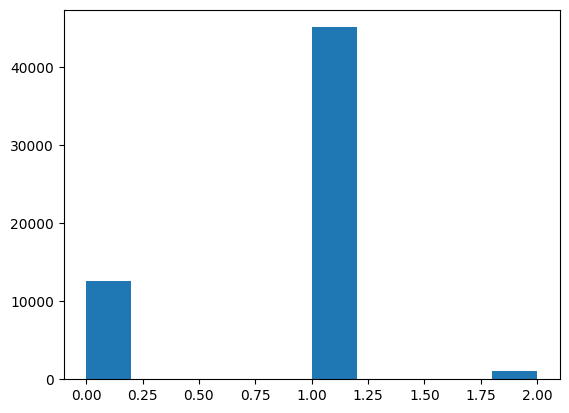

In [121]:
import matplotlib.pyplot as plt
plt.hist(y_encoded)
plt.show()

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [123]:
import xgboost as xgb
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [124]:
params = {"objective": "multi:softprob", "tree_method": "hist", "num_class": 3}
n = 100

evals = [(dtest_clf, "validation"), (dtrain_clf, "train")]

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10
)

[0]	validation-mlogloss:0.70243	train-mlogloss:0.70234
[10]	validation-mlogloss:0.02782	train-mlogloss:0.02746
[20]	validation-mlogloss:0.00171	train-mlogloss:0.00145
[30]	validation-mlogloss:0.00031	train-mlogloss:0.00014
[40]	validation-mlogloss:0.00025	train-mlogloss:0.00005
[50]	validation-mlogloss:0.00027	train-mlogloss:0.00004
[60]	validation-mlogloss:0.00029	train-mlogloss:0.00004
[70]	validation-mlogloss:0.00030	train-mlogloss:0.00004
[80]	validation-mlogloss:0.00032	train-mlogloss:0.00004
[90]	validation-mlogloss:0.00033	train-mlogloss:0.00004
[99]	validation-mlogloss:0.00032	train-mlogloss:0.00004


In [125]:
input_df = post_score_df[post_score_df['recommend'].isna()]

In [126]:
input_df = input_df.drop('recommend', axis=1)

In [127]:
input_df = input_df.drop('classes', axis=1)

In [128]:
cats = input_df.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    input_df[col] = input_df[col].astype('category')

In [129]:
dinput_df = xgb.DMatrix(input_df, enable_categorical=True)

In [130]:
predicted_y = model.predict(dinput_df)

In [131]:
len(predicted_y)

393818

In [132]:
type(predicted_y)

numpy.ndarray

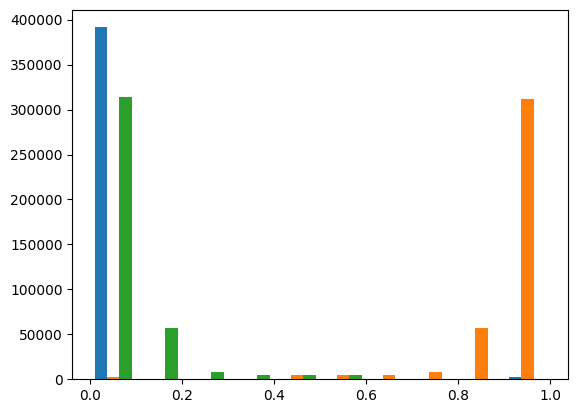

In [133]:
import matplotlib.pyplot as plt
plt.hist(predicted_y)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

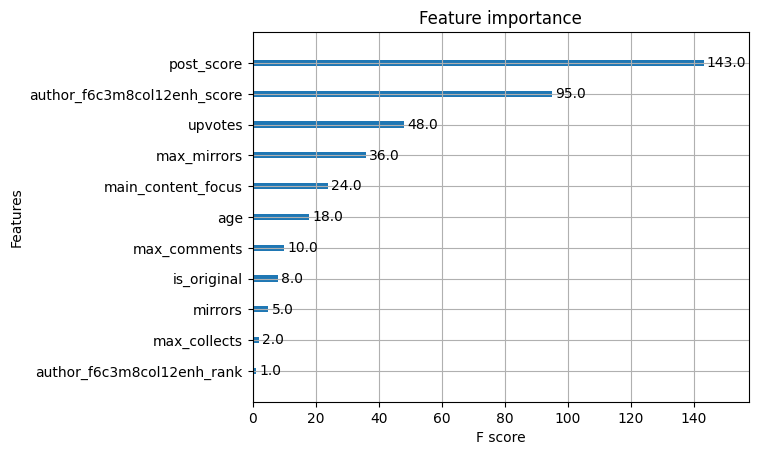

In [134]:
from xgboost import plot_importance
plot_importance(model)

In [135]:
import numpy as np
predicted_y_int = np.rint(predicted_y)

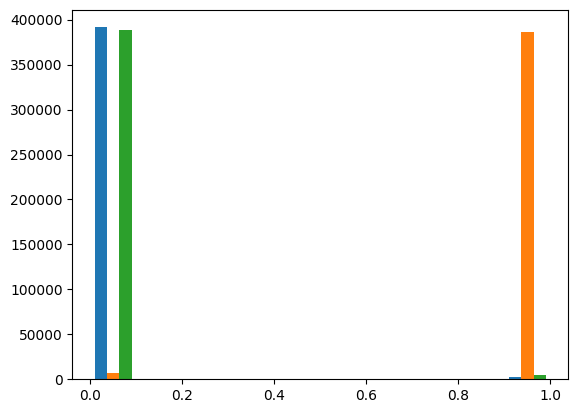

In [136]:
import matplotlib.pyplot as plt
plt.hist(predicted_y_int)
plt.show()

In [137]:
predicted_y_int

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [138]:
enc.inverse_transform(predicted_y_int)

ValueError: Shape of the passed X data is not correct. Expected 1 columns, got 3.